<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dense-SIFT-in-a-Gaussian-Pyramid" data-toc-modified-id="Dense-SIFT-in-a-Gaussian-Pyramid-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dense SIFT in a Gaussian Pyramid</a></span></li><li><span><a href="#Feature-Extraction" data-toc-modified-id="Feature-Extraction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Extraction</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classification</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Classifier-optimization" data-toc-modified-id="Classifier-optimization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classifier optimization</a></span></li><li><span><a href="#MLP-Classifier-Optimization" data-toc-modified-id="MLP-Classifier-Optimization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>MLP Classifier Optimization</a></span></li></ul></div>

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('../../'))

In [2]:
import logging
from random import shuffle

import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize, scale
from sklearn.svm import SVC
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
import pandas as pd
from tpot import TPOTClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import warnings
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import pyramid_gaussian
warnings.filterwarnings('ignore')

from src.misc.data import load_labelled, load_unlabelled
from src.misc.ops import crop_to_square, resize
from src.misc.visualise import *

In [3]:
# Set up logging.
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

# Load training data.
x, y = load_labelled('../../data/training')
labels = sorted(set(y))

INFO: Loading labelled data from C:\Users\hp\Desktop\University of Southampton\MSc AI\Computer Vision\Assignments\3\comp6223-scene-recognition-master\src\misc/../../data/training.
INFO: Class name          Number of samples   
INFO: ----------------------------------------
INFO: bedroom             100                 
INFO: Coast               100                 
INFO: Forest              100                 
INFO: Highway             100                 
INFO: industrial          100                 
INFO: Insidecity          100                 
INFO: kitchen             100                 
INFO: livingroom          100                 
INFO: Mountain            100                 
INFO: Office              100                 
INFO: OpenCountry         100                 
INFO: store               100                 
INFO: Street              100                 
INFO: Suburb              100                 
INFO: TallBuilding        100                 
INFO: Loaded 15 class

In [4]:
x_np = np.array(x)
y_np = np.array(y)

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=2019)
for train_index, test_index in sss.split(x_np, y_np):
    x_train, x_test = x_np[train_index], x_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

## Dense SIFT in a Gaussian Pyramid

In [24]:
def pyramids(image, step_size = 5):
    descriptors = []
    scaled = []
    for resized in pyramid_gaussian(image, downscale=1.2):
        scaled.append(resized)
    for i in scaled[:4]:
        sift = cv2.xfeatures2d.SIFT_create()
        image8bit = cv2.normalize(i, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image8bit.shape[0], step_size) 
                                    for x in range(0, image8bit.shape[1], step_size)]
        # kps, descs = sift.detectAndCompute(image8bit, None)
        #print(np.array(descs).shape)
        kps, descs = sift.compute(image8bit, kp)
        descriptors.append(descs)
    return np.vstack(descriptors) 

In [7]:
flatten = lambda l: (item for sublist in l for item in sublist)
patchgen = lambda x: (pyramids(img) for img in x)
zero_mean = lambda x: (scale(patches) for patches in x)
unit_len = lambda x: (normalize(patches) for patches in x)
histgen = lambda x, quantizer: (np.histogram(
    quantizer.predict(patches),
    bins=quantizer.cluster_centers_.shape[0],
#     bins=500,
    density=False)[0]/quantizer.cluster_centers_.shape[0] for patches in x)

## Feature Extraction

In [8]:
patches_train = list(unit_len(zero_mean(patchgen(x_train))))
patches_test = list(unit_len(zero_mean(patchgen(x_test))))
bovw_train = list(flatten(patches_train))

In [9]:
kmeans = MiniBatchKMeans(n_clusters=250, random_state=2019, batch_size=50000)

In [10]:
kmeans.fit(bovw_train)

MiniBatchKMeans(batch_size=50000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=250, n_init=3, random_state=2019,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [11]:
svm_train = list(histgen(patches_train, kmeans))
svm_test = list(histgen(patches_test, kmeans))

## Classification

In [12]:
clf = OneVsRestClassifier(SVC(kernel='linear', C=4.0)).fit(svm_train, y_train)
y_pred = clf.predict(svm_train)
accuracy_score(y_train, y_pred)

0.9741293532338309

In [13]:
y_pred = clf.predict(svm_test)
accuracy_score(y_test, y_pred)

0.5595959595959596

In [22]:
clf = OneVsRestClassifier(MLPClassifier(batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False)).fit(svm_train, y_train)
y_pred = clf.predict(svm_test)
accuracy_score(y_test, y_pred)

0.6202020202020202

## Optimization

In [25]:
n_cls = []
acc = []
for size in range(50, 800, 100):
    kmeans = MiniBatchKMeans(n_clusters= size, random_state=2019, batch_size=50000)
    kmeans.fit(bovw_train)
    svm_train = list(histgen(patches_train, kmeans))
    svm_test = list(histgen(patches_test, kmeans))
    clf = MLPClassifier(batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False).fit(svm_train, y_train)
    y_pred = clf.predict(svm_test)
    res = accuracy_score(y_test, y_pred)
    print("Number of clusters: " + str(size) + ", Accuracy: " + str(res))
    acc.append(res)
    n_cls.append(size)

Number of clusters: 50, Accuracy: 0.501010101010101
Number of clusters: 150, Accuracy: 0.5898989898989899
Number of clusters: 250, Accuracy: 0.6222222222222222
Number of clusters: 350, Accuracy: 0.6080808080808081
Number of clusters: 450, Accuracy: 0.6060606060606061
Number of clusters: 550, Accuracy: 0.5737373737373738
Number of clusters: 650, Accuracy: 0.6202020202020202


KeyboardInterrupt: 

(0, 1)

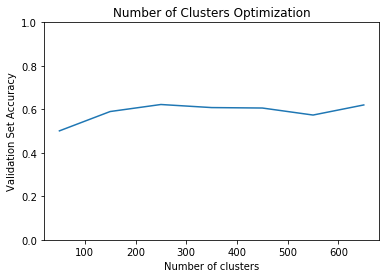

In [26]:
plt.plot(n_cls, acc)
plt.xlabel('Number of clusters')
plt.ylabel('Validation Set Accuracy')
plt.title('Number of Clusters Optimization')
plt.ylim([0, 1])

In [29]:
n_cls = []
acc = []
for step in range(10, 25, 5): 
    patches_train = list(unit_len(zero_mean([pyramids(img, step_size = step) for img in x_train])))
    patches_test = list(unit_len(zero_mean([pyramids(img, step_size = step) for img in x_test])))
    bovw_train = list(flatten(patches_train))
    kmeans = MiniBatchKMeans(n_clusters= 250, random_state=2019, batch_size=50000)
    kmeans.fit(bovw_train)
    svm_train = list(histgen(patches_train, kmeans))
    svm_test = list(histgen(patches_test, kmeans))
    clf = MLPClassifier(batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False).fit(svm_train, y_train)
    y_pred = clf.predict(svm_test)
    res = accuracy_score(y_test, y_pred)
    print("Step Size: " + str(step) + ", Accuracy: " + str(res))
    acc.append(res)
    n_cls.append(size)

Step Size: 10, Accuracy: 0.509090909090909
Step Size: 15, Accuracy: 0.4


KeyboardInterrupt: 

In [ ]:
plt.plot(n_cls, acc)
plt.xlabel('Number of clusters')
plt.ylabel('Validation Set Accuracy')
plt.title('Number of Clusters Optimization')
plt.ylim([0, 1])

## Classifier optimization

In [15]:
models = [('Support Vector Machine', SVC()), 
          ('Naive Bayes', GaussianNB()), 
          ('MLPClassifier',  MLPClassifier()), 
          ('Random Forest', RandomForestClassifier()), 
          ('AdaBoostClassifier', AdaBoostClassifier()),
          ('GaussianProcess', GaussianProcessClassifier()),
          ('DecisionTree', DecisionTreeClassifier()),
          ('KNearest',  KNeighborsClassifier())]
results = []
names = []
for name, model in models:
    clf = model.fit(svm_train, y_train)
    y_pred = clf.predict(svm_test)
    res = accuracy_score(y_test, y_pred)
    results.append(res)
    names.append(name)
    print(str(name) + ' accuracy: ' + str(res))

Support Vector Machine accuracy: 0.38181818181818183
Naive Bayes accuracy: 0.5474747474747474
MLPClassifier accuracy: 0.6262626262626263
Random Forest accuracy: 0.3797979797979798
AdaBoostClassifier accuracy: 0.20404040404040405
GaussianProcess accuracy: 0.5616161616161616
DecisionTree accuracy: 0.2404040404040404
KNearest accuracy: 0.42828282828282827


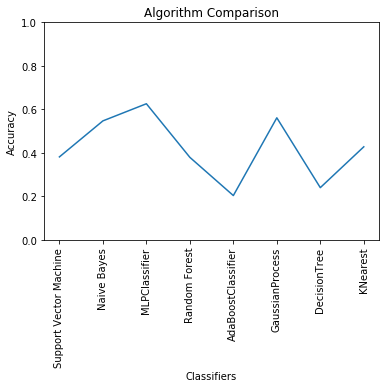

In [16]:
plt.title('Algorithm Comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.plot(names, results)
plt.ylim([0, 1])
plt.show()

## MLP Classifier Optimization

In [17]:
le = preprocessing.LabelEncoder()
train = le.fit_transform(y_train)
enc = le.fit_transform(y_test)

In [18]:
parameters = {'solver': ['lbfgs', 'sgd', 'adam'],
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes' : [(100,), (50, 50), (20, 70), (70, 20)],
              'alpha': list(np.linspace(0.00001, 0.01, 10, dtype = float))}
               
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict= {'sklearn.neural_network.MLPClassifier': parameters}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(np.array(svm_train), train)

Generation 1 - Current best internal CV score: 0.5947303921568627
Generation 2 - Current best internal CV score: 0.5947303921568627
Generation 3 - Current best internal CV score: 0.5947303921568627
Generation 4 - Current best internal CV score: 0.5947303921568627
Generation 5 - Current best internal CV score: 0.5947303921568627

Best pipeline: MLPClassifier(input_matrix, activation=tanh, alpha=0.00556, hidden_layer_sizes=(100,), solver=adam)


TPOTClassifier(config_dict={'sklearn.neural_network.MLPClassifier': {'activation': ['identity',
                                                                                    'logistic',
                                                                                    'tanh',
                                                                                    'relu'],
                                                                     'alpha': [1e-05,
                                                                               0.0011200000000000001,
                                                                               0.00223,
                                                                               0.0033400000000000005,
                                                                               0.00445,
                                                                               0.00556,
                                                                     

In [20]:
acc6 = tpot_classifier.score(np.array(svm_test), enc)
print(acc6)

0.6080808080808081


In [21]:
tpot_classifier.fitted_pipeline_

Pipeline(memory=None,
         steps=[('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=0.00556,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(100,),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)